# Feature Based Panoramic Image Stitching
# 基于特征的全景图像拼接

**Задача.** Даны два изображения. Необходимо их "склеить" в одно изображение.\
** 任务 ** 给出两幅图像。 需要将它们 "粘合 "成一幅图像。

**Алгоритм решения.**
1.   Обнаружить особые точки и получить их дескрипторы.
2.   Обнаружить сопадающие точки, присутствующие на обоих изображениях.
3.   Применить алгоритм RANSAC для улучшения сопоставления точек.
4.   Применить перспективное преобразование одного изображения относительно другого.
5.   "Склеить" изображения.


**1. 检测特殊点并获取其描述符。 2. 检测两幅图像中的重合点。 3. 应用 RANSAC 算法改进点的匹配。 4. 将一张图像相对于另一张图像进行透视变换。 5. 将图像 "粘合 "在一起。



In [2]:
import cv2 as cv
import numpy as np
#import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
folder = "drive/MyDrive/cv_data/"

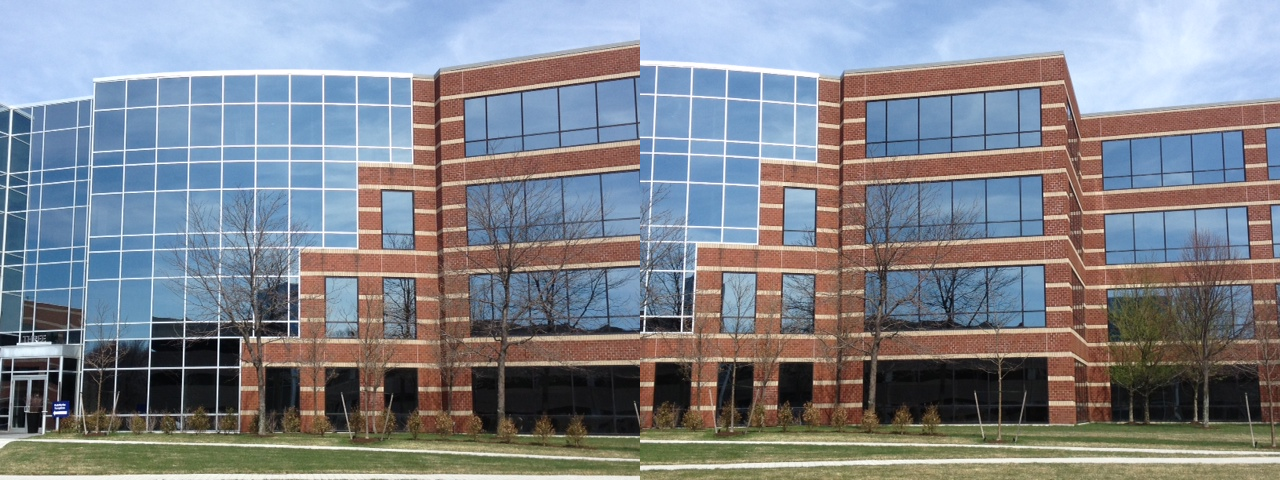

In [3]:
img1 = cv.imread(folder+"building/building3.jpg")
img2 = cv.imread(folder+"building/building4.jpg")

cv2_imshow(np.concatenate((img1, img2), axis=1))

# 1. Извлечение особых точек
Используем детектор ORB для извлечения ключевых точек.

# 1. 提取特殊点 
使用 ORB 检测器提取关键点。

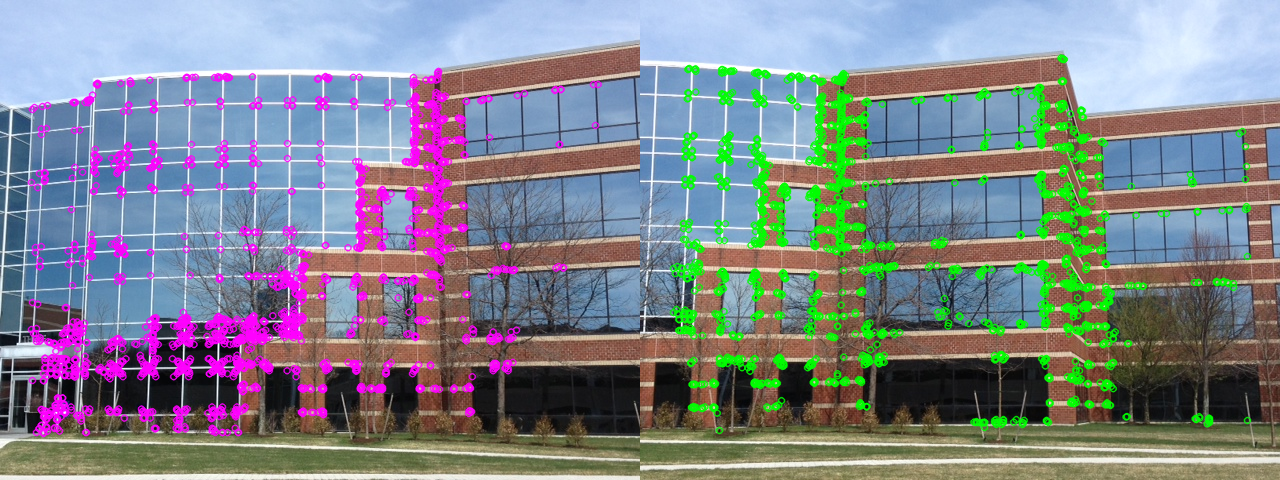

In [4]:
orb = cv.ORB_create(nfeatures=2000)

# Find the key points and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

img1_kp = cv.drawKeypoints(img1, keypoints1, None, (255, 0, 255))
img2_kp = cv.drawKeypoints(img2, keypoints2, None, (0, 255, 0))
cv2_imshow(np.concatenate( (img1_kp, img2_kp), axis=1))

In [5]:
print("Descriptor of the first keypoint for first image: ")
print(descriptors1[0])
print("Descriptor of the first keypoint for second image: ")
print(descriptors2[0])

Descriptor of the first keypoint for first image: 
[ 60  65  22 228  21 102  66  68 197 128 250   3  67 185  33  72 248 180
  46 240   8 179  81 140 251 229 131  19 233 123 112  10]
Descriptor of the first keypoint for second image: 
[136 142 152  61 178 187  52 191  95  47 118 240 175  35 162  81 215  75
 174   8 182 252  69  63 238 247  52 193 208 216 137   9]


# 2. Сопоставление особых точек
Вспомогательная функция для визуализации сопоставленных точек.

# 2. 匹配特殊点 
显示匹配点的辅助功能。

In [6]:
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
  r1, c1 = img1.shape[:2]
  r2, c2 = img2.shape[:2]

  # Create a blank image with the size of the first image + second image
  output_img = np.zeros((max([r1, r2]), c1+c2, 3), dtype='uint8')
  output_img[:r1, :c1, :] = img1 #np.dstack([img1, img1, img1])
  output_img[:r2, c1:c1+c2, :] = img2 #np.dstack([img2, img2, img2])

  for match in matches:
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt

    # Draw circles on the keypoints
    cv.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
    cv.circle(output_img, (int(x2)+c1,int(y2)), 4, (0, 255, 255), 1)

    # Connect the same keypoints
    cv.line(output_img, (int(x1),int(y1)), (int(x2)+c1,int(y2)), (0, 255, 255), 1)

  return output_img

Сопоставим ключевые точки на двух изображениях.

让我们比较一下这两张图片的关键点。

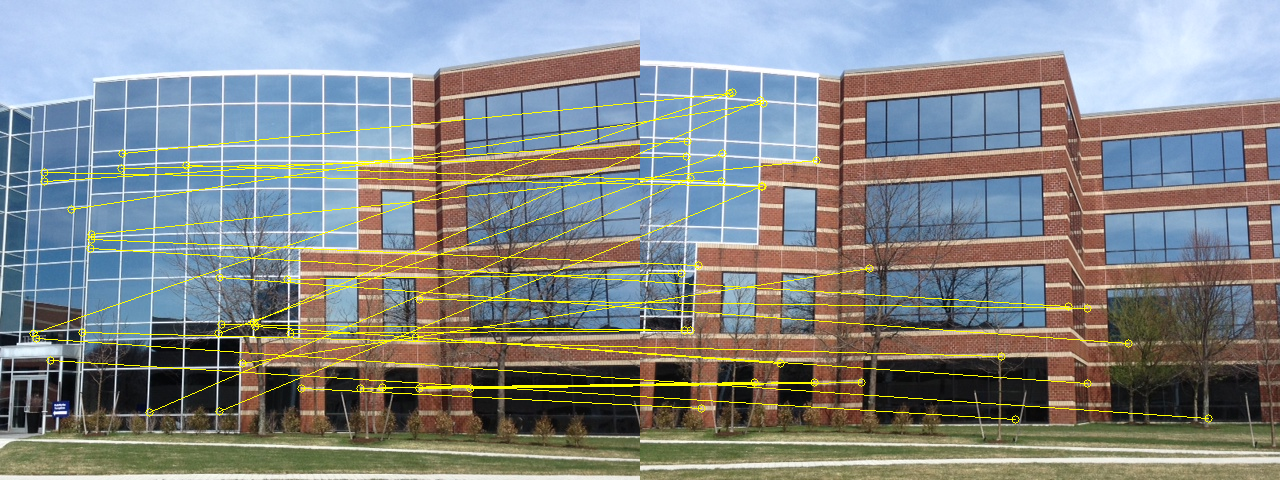

In [7]:
# Create a BFMatcher object.
# It will find all of the matching keypoints on two images
bf = cv.BFMatcher_create(cv.NORM_HAMMING)

# Find matching points
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

all_matches = []
for m, n in matches:
  all_matches.append(m)

img3 = draw_matches(img1, keypoints1, img2, keypoints2, all_matches[:30])
cv2_imshow(img3)


Найдем лучшие совпадения.

让我们来寻找最佳匹配。

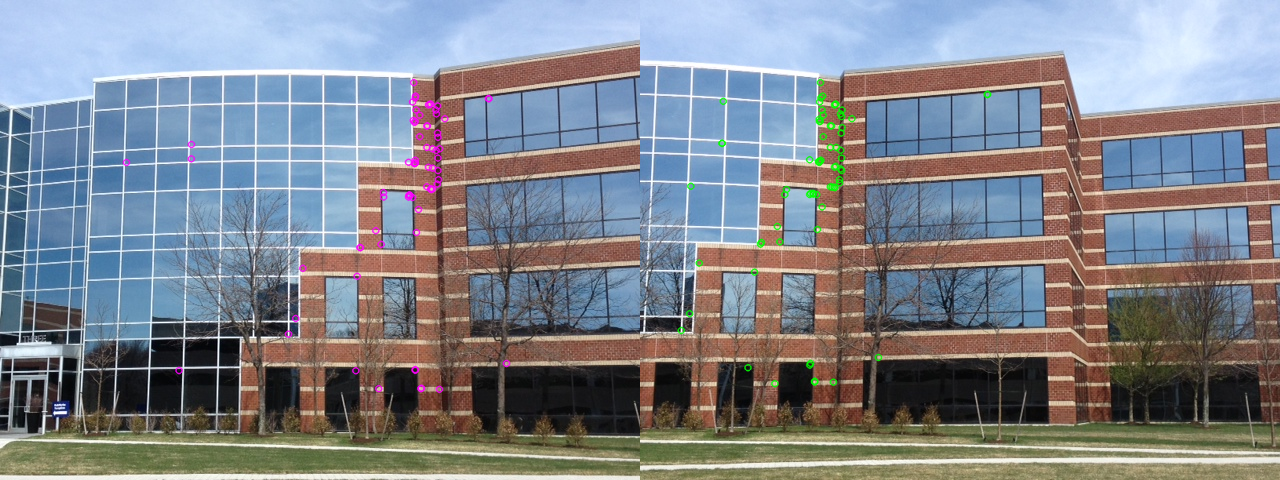

In [8]:
good = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good.append(m)

img1_kp = cv.drawKeypoints(img1, [keypoints1[m.queryIdx] for m in good], None, (255, 0, 255))
img2_kp = cv.drawKeypoints(img2, [keypoints2[m.trainIdx] for m in good], None, (0, 255, 0))
cv2_imshow(np.concatenate( (img1_kp, img2_kp), axis=1))

# 3. Склейка изображений

# 3. 拼接图像

Для того, чтобы построить матрицу гомографии (преобразование, которое отображает точки одного изображения в соответствующие точки другого изображения) нужно получить как минимум 4 точки на первом изображении и соответствующие им 4 точки на втором изображении. Эти точки связаны гомографией, поэтому мы можем применить преобразование, чтобы изменить перспективу второго изображения, используя первое изображение в качестве опорной системы.

为了构建同构矩阵（将一幅图像中的点映射到另一幅图像中相应点的变换），您需要在第一幅图像中获取至少 4 个点，并在第二幅图像中获取相应的 4 个点。 这些点通过同轴变换连接在一起，因此我们可以将第一幅图像作为参考系，应用变换来改变第二幅图像的透视。


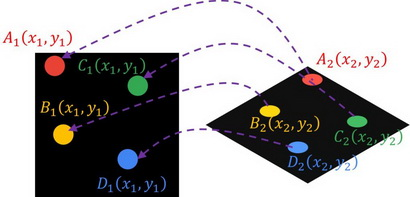

Далее создадим два списка с точками:
*   list_of_points_1 представляет координаты эталонного изображения,
*   temp_points представляет координаты второго изображения, которое мы хотим преобразовать.

Затем мы применим перспективное преобразование к точкам на втором изображении.

Наконец, деформируем второе изображение с помощью функции cv2.warpPerspective().

接下来，让我们创建两个包含点的列表： 
* list_of_points_1 表示参考图像的坐标，
* temp_points 表示我们要变换的第二幅图像的坐标。   
然后，我们对第二幅图像中的点进行透视变换。  
最后，我们使用 cv2.warpPerspective() 函数对第二幅图像进行变形。

In [9]:
def warpImages(img1, img2, H):
  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

  translation_dist = [-x_min, -y_min]

  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv.warpPerspective( img2, H_translation.dot(H), (x_max-x_min, y_max-y_min) )
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

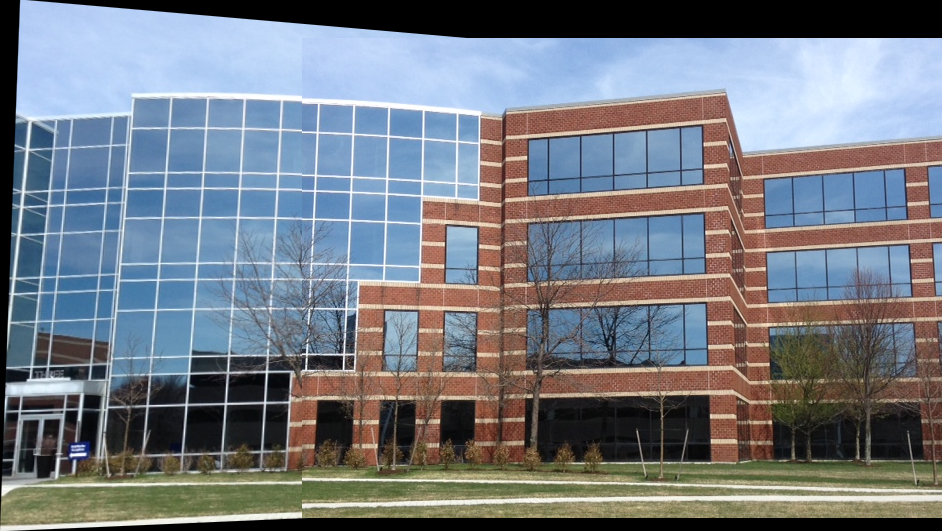

In [10]:
MIN_MATCH_COUNT = 10 # Set minimum match condition

if len(good) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Вычисление матрицы гомографии
    M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

    result = warpImages(img2, img1, M)

    cv2_imshow(result)